<a href="https://colab.research.google.com/github/H31muth/Challenge-Telecom-X/blob/main/Challenge_TelecomX_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Challenge Telecom X: análisis de evasión de clientes - Parte 2**

**Carga de Datos y Verificación de Nulos**

In [98]:
# Importación de las librerías
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import resample
import warnings

warnings.filterwarnings('ignore')

# Import SMOTE
use_smote = False
try:
    from imblearn.over_sampling import SMOTE
    use_smote = True
except Exception:
    use_smote = False

TEST_SIZE = 0.2
RANDOM_STATE = 42
CHURN_THRESHOLD_FEATURE_IMPORTANCE = 0.22
CV = 3 # reduce CV para entornos con recursos limitados
N_JOBS = 1 # evita spawn de muchos procesos en entornos restrictivos

# Cargar el archivo CSV
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge 2 - TelecomX/datos_tratados.csv')

# Verificar si hay valores nulos en el DataFrame
null_values = df.isnull().sum()
print("Valores nulos por columna:")
print(null_values[null_values > 0])

Valores nulos por columna:
Series([], dtype: int64)


**Eliminación de Columnas Irrelevantes**

In [99]:
# La columna customerID es un identificador único y no aporta valor predictivo
df.drop('customerID', axis=1, inplace=True)


In [100]:
# Separación de variables predictoras (X) y variable objetivo (y)
# La variable objetivo es 'Churn_Encoded'
X = df.drop('Churn_Encoded', axis=1)
y = df['Churn_Encoded']

**Encoding**

In [101]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print("\nColumnas categóricas a codificar:", categorical_cols)



Columnas categóricas a codificar: ['Churn', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [102]:
df = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print("\nDimensiones del dataset después de la codificación:", X_encoded.shape)
print("\nPrimeras 5 filas del dataset codificado:")
print(X_encoded.head())


Dimensiones del dataset después de la codificación: (7267, 34)

Primeras 5 filas del dataset codificado:
   SeniorCitizen  tenure    Total  Monthly  Cuentas_Diarias  \
0              0       9   593.30     65.6         2.186667   
1              0       9   542.40     59.9         1.996667   
2              0       4   280.85     73.9         2.463333   
3              1      13  1237.85     98.0         3.266667   
4              1       3   267.40     83.9         2.796667   

   PhoneService_Encoded  MultipleLines_Encoded  OnlineSecurity_Encoded  \
0                     1                      0                       0   
1                     1                      1                       0   
2                     1                      0                       0   
3                     1                      0                       0   
4                     1                      0                       0   

   OnlineBackup_Encoded  DeviceProtection_Encoded  ...  DeviceProtecti

In [103]:
# Visualizar proporción
churn_ratio = df['Churn_Yes'].value_counts(normalize=True)
print("Proporción de cancelación (Churn):\n", churn_ratio)

Proporción de cancelación (Churn):
 Churn_Yes
False    0.74281
True     0.25719
Name: proportion, dtype: float64


**Análisis de Correlación y Selección de Variables**

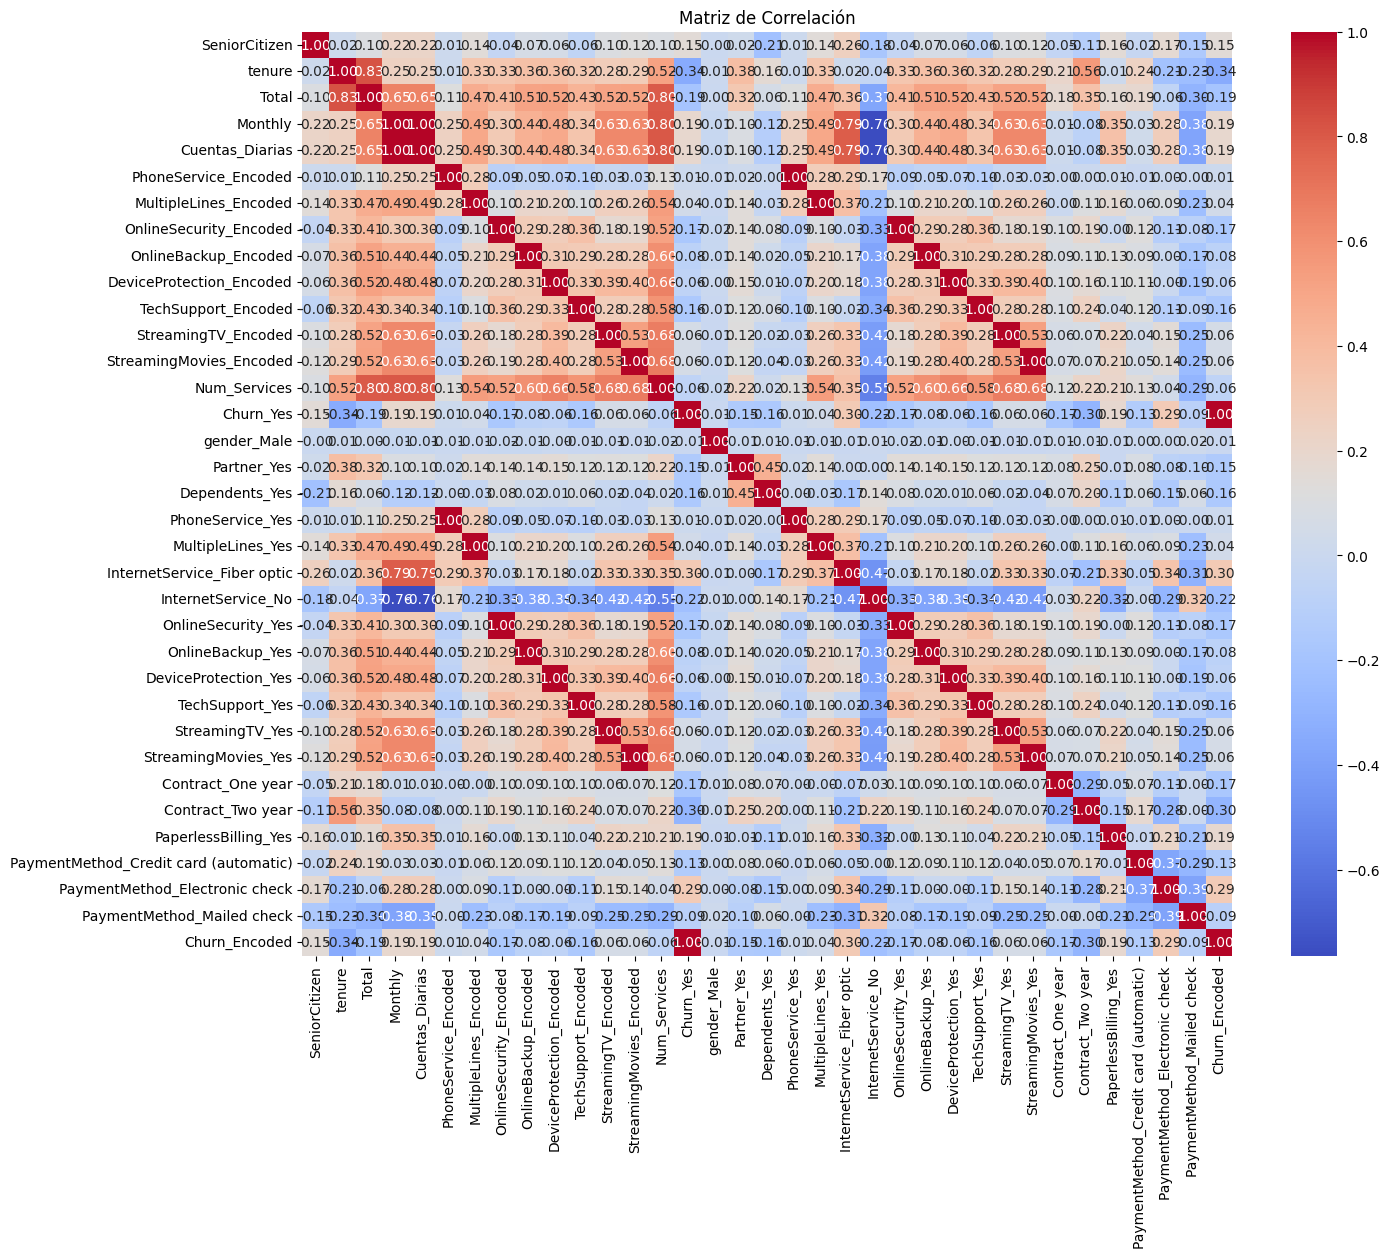


Correlación con 'Churn_Encoded':
Churn_Yes                                1.000000
Churn_Encoded                            1.000000
InternetService_Fiber optic              0.300949
PaymentMethod_Electronic check           0.294626
Monthly                                  0.189866
Cuentas_Diarias                          0.189866
PaperlessBilling_Yes                     0.186666
SeniorCitizen                            0.146733
StreamingTV_Encoded                      0.062430
StreamingTV_Yes                          0.062430
StreamingMovies_Encoded                  0.060586
StreamingMovies_Yes                      0.060586
MultipleLines_Yes                        0.039343
MultipleLines_Encoded                    0.039343
PhoneService_Yes                         0.012571
PhoneService_Encoded                     0.012571
gender_Male                             -0.009555
DeviceProtection_Encoded                -0.063452
DeviceProtection_Yes                    -0.063452
Num_Services    

In [104]:
# Matriz de Correlación
import seaborn as sns
import matplotlib.pyplot as plt

# Combine X_encoded and y for correlation analysis
df_encoded_corr = X_encoded.copy()
df_encoded_corr['Churn_Encoded'] = y

# Calcular la matriz de correlación para las variables numéricas y la variable objetivo
correlation_matrix = df_encoded_corr.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# Correlación de las variables con 'Churn_Encoded'
churn_correlation = correlation_matrix['Churn_Encoded'].sort_values(ascending=False)
print("\nCorrelación con 'Churn_Encoded':")
print(churn_correlation)

Las variables con mayor correlación (positiva o negativa) con Churn_Encoded pueden ser las más importantes para el modelo predictivo.
Una correlación positiva ambas variables aumentan. Una correlación negativa sugiere lo contrario.

In [105]:
# Separar variables
X = df.drop('Churn_Yes', axis=1)
y = df['Churn_Yes']

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)



In [106]:
# Estandarizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bal)

## **Modelado Predictivo**

In [107]:

# Dividir los datos en conjuntos de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_bal, test_size=0.3, random_state=42, stratify=y_bal)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (7557, 33)
Tamaño del conjunto de prueba: (3239, 33)


##**Entrenamiento de los modelos**

**Modelo 1: Regresión Logística**

In [108]:

# Inicializar y entrenar el modelo de Regresión Logística
log_reg = LogisticRegression(random_state=42, solver='liblinear')
log_reg.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_log_reg = log_reg.predict(X_test)

**Modelo 2: Random Forest**

In [114]:
# Inicializar y entrenar el modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = rf.predict(X_test)

## **Evaluación de los Modelos**

In [115]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(y_true, y_pred, model_name):
    """
    Función para evaluar y mostrar las métricas de un modelo.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"--- Evaluación del modelo: {model_name} ---")
    print(f"Exactitud (Accuracy): {accuracy:.4f}")
    print(f"Precisión (Precision): {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nMatriz de Confusión:")
    print(cm)
    print("-------------------------------------------\n")

# Evaluar Regresión Logística
evaluate_model(y_test, y_pred_log_reg, "Regresión Logística")

# Evaluar Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

--- Evaluación del modelo: Regresión Logística ---
Exactitud (Accuracy): 0.8447
Precisión (Precision): 0.8505
Recall: 0.8363
F1-Score: 0.8434

Matriz de Confusión:
[[1382  238]
 [ 265 1354]]
-------------------------------------------

--- Evaluación del modelo: Random Forest ---
Exactitud (Accuracy): 0.8481
Precisión (Precision): 0.8564
Recall: 0.8363
F1-Score: 0.8462

Matriz de Confusión:
[[1393  227]
 [ 265 1354]]
-------------------------------------------



**Importancia de las columnas con**  *features_importances_*  

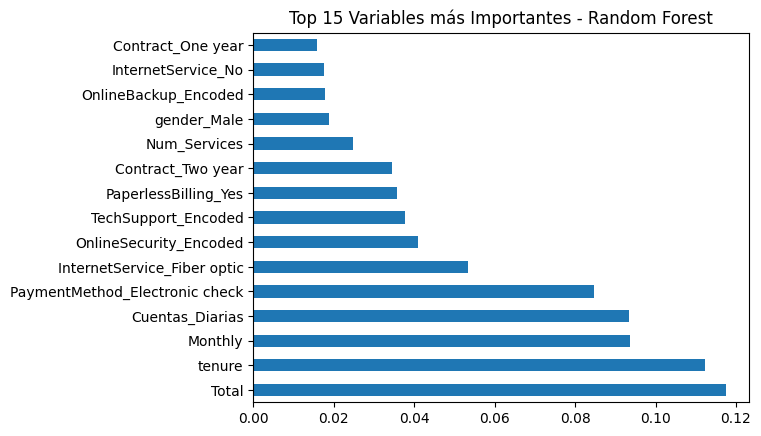

In [118]:
# Importancia en Random Forest
importancias = pd.Series(rf.feature_importances_, index=X.columns)
importancias.sort_values(ascending=False).head(15).plot(kind='barh')
plt.title("Top 15 Variables más Importantes - Random Forest")
plt.show()

Ambos modelos tienen un desempeño similar, ligeramente mejor Random Forest
Las variables más importantes son en orden de importancia:
1.- tenure
2.- Monthly
3.- Cuentas_diarias
4.- Metodo de pago

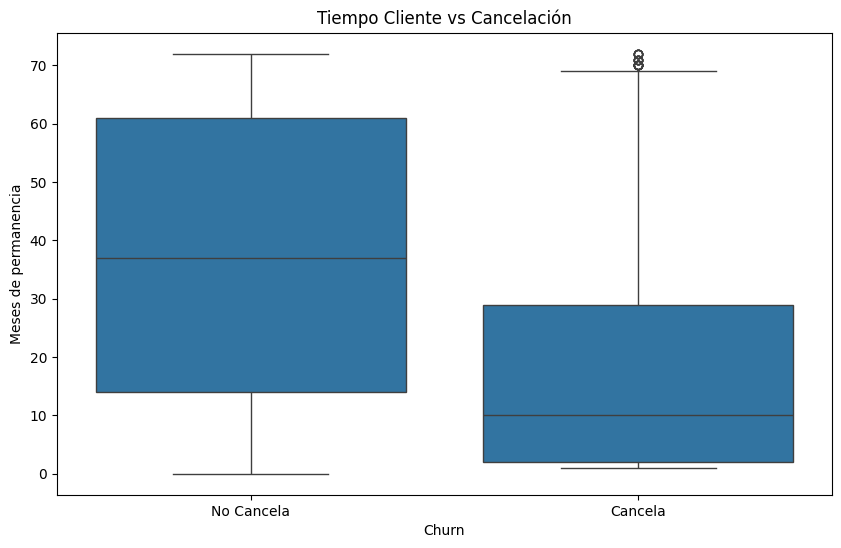

In [122]:
# Gráfico boxplot de tenure vs churn
df_temp = df.copy()
df_temp['Churn'] = y

plt.figure(figsize=(10,6))
sns.boxplot(x='Churn', y='tenure', data=df_temp)
plt.title("Tiempo Cliente vs Cancelación")
plt.xticks([0,1], ['No Cancela', 'Cancela'])
plt.ylabel("Meses de permanencia")
plt.show()

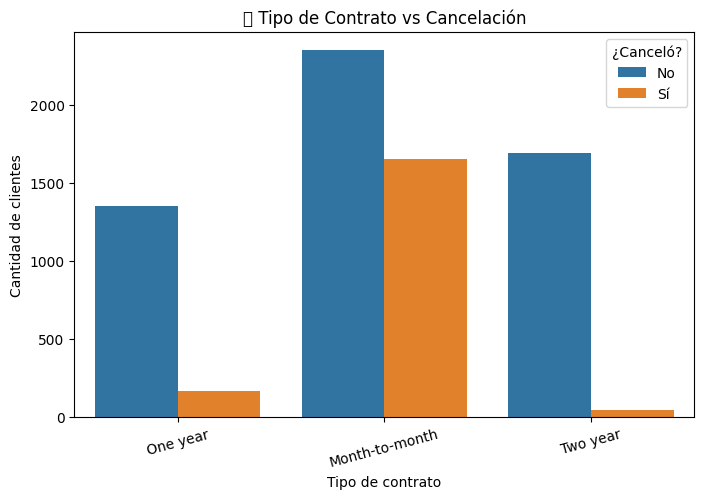

In [127]:
# Gráfico de barras de Tipo de Contrato vs Cancelación
df_temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge 2 - TelecomX/datos_tratados.csv')
df_temp['Churn'] = df_temp['Churn_Encoded'].map({0: 'No', 1: 'Sí'})
plt.figure(figsize=(8,5))
sns.countplot(data=df_temp, x='Contract', hue='Churn')
plt.title("📄 Tipo de Contrato vs Cancelación")
plt.xlabel("Tipo de contrato")
plt.ylabel("Cantidad de clientes")
plt.legend(title="¿Canceló?")
plt.xticks(rotation=15)
plt.show()

# **INFORME FINAL: ANÁLISIS DE CANCELACIÓN DE CLIENTES**

**Objetivo**

Desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

**Modelos Evaluados:**
- Regresión Logística
- Random Forest

**Resultados**
De acuerdo a los resultados entregados, el modelo Random Forest es levemente superior, sin embargo, los modelos pueden mejorar con una optimización de hiperparámetros a través de GridSearchCV.

**Estrategias de Retención de clientes:**

1. Los clientes con contratos mensuales tienen mayor riesgo de cancelación. Se pueden ofrecer descuentos o beneficios para incentivar la migración a contratos de un año o dos.
2. Servicio de Internet: La fibra óptica parece estar relacionada con mayor churn. Es fundamental investigar la calidad de este servicio y resolver posibles problemas técnicos.
3. Mejorar la experiencia de pago, especialmente con clientes que utilizan "electronic check".
4. Mejorar los planes de comunicaciones personalizadas a los segmentos con mayor riesgo: implementar programas de bienvenida para los nuevos y de fidelización para los antiguos.
5. Implementar campañas a clientes de bajo gasto para mejorar servicios adicionales.